<a href="https://colab.research.google.com/github/gpostill/-Applied-ML-for-Healthcare-Course-Datathon4/blob/main/Datathon4_(model_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Datathon 4
<b> Team: </b> Gemma Postill, Sarra Ali, Myron Moskalyk <br>
<b> Team Number: </b> 10<br>
<b> Course: </b> CHL5239 Fall 2023<br>
<b> Date: </b> 2023-10-31 <br>
<b> Dataset: </b> Mortality Dataset for ICU Admission <br>

**Clinical Scenario**

The accurate prediction of mortality in the first 24 hours following admission to an Intensive Care Unit (ICU) is an important task clinically for both patients and providers. Early and accurate prediction of mortality can enable effective and ethical resource allocation and aids in strategic planning of care, allowing medical teams to prioritize interventions, tailor treatment plans, and make informed decisions about the potential benefits of aggressive versus palliative care strategies. Furthermore, early mortality predictions provide invaluable information to families, facilitating difficult conversations and helping loved ones set realistic expectations, prepare for potential outcomes, and make time-sensitive decisions about end-of-life care. Recognizing this, this datathon aims to explore the power of Machine Learning models to predict mortality using real-world data from that critical first day in the ICU, all with the goal of enhancing patient care and supporting families in their tough moments.


In [1]:
#mount drive - for Import Option 1
from google.colab import drive
drive.mount('/content/drive')


#importing the necessary packages
from google.colab import files
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, confusion_matrix, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import warnings
warnings.filterwarnings('ignore')


Mounted at /content/drive


In [ ]:
#Defining necessary function

def plot_histograms(og_df, imp_df, variables, bins=30):
    import matplotlib.pyplot as plt

    for variable in variables:
        plt.figure(figsize=(10, 4))

        # Histogram for the original data (excluding missing values)
        plt.subplot(1, 2, 1)
        plt.hist(og_df[variable].dropna(), bins=bins, alpha=0.7, color='blue', label='Original')
        plt.title(f'Original Distribution of {variable}')
        plt.xlabel(variable)
        plt.ylabel('Frequency')

        # Histogram for the imputed data
        plt.subplot(1, 2, 2)
        plt.hist(imp_df[variable], bins=bins, alpha=0.7, color='green', label='Imputed')
        plt.title(f'Imputed Distribution of {variable}')
        plt.xlabel(variable)
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.legend()
        plt.show()


# Part 1: Import Data & Libraries

In [2]:
#Importing the data
df = pd.read_csv("drive/My Drive/datathon4.csv") #Gemma

df.head()


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


# Part 2: Description of Data

We will begin by identifying any missing data in our dataset, to identify if there are variables that have a significant proportion of missing data and therefore cannot be used. We will also describe our data further by identifying the distribution of each predictor variable, identifying mean and standard deviation/IQR for continuous variables, and proportions of each level for categorical variables.


In [3]:
#Get shape of df
print(df.shape) # there are 91713 ROWS and 186 COLUMNS

# Display the column names, data types of each columnm, and explore for NA values
print(df.isna().sum())

#Do a descriptive analysis of all variables (numerical and categorical)
print(df.describe(include='all'))
  #This is done to look for outliers and missingness ("0" e.g., BMI = 0 which would be implausible)


# Lets look at some strata by comorbidity/condition
print(np.shape(df))
print('There are ' + str(len(df['hospital_id'].unique()))+ ' hospital locations')
print('There are ' + str((df['aids']==1).sum()) + ' patients with aids')
print('There are ' + str((df['cirrhosis']==1).sum()) + ' patients with cirrhosis')
print('There are ' + str((df['diabetes_mellitus']==1).sum()) + ' patients with diabetes mellitus')
print('There are ' + str((df['hepatic_failure']==1).sum()) + ' patients with hepatic failure')
print('There are ' + str((df['immunosuppression']==1).sum()) + ' patients with immunosuppresion')
print('There are ' + str((df['leukemia']==1).sum()) + ' patients with leukemia')
print('There are ' + str((df['lymphoma']==1).sum()) + ' patients with lymphoma')
print('There are ' + str((df['solid_tumor_with_metastasis']==1).sum()) + ' patients with metastasis')


(91713, 186)
encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64
         encounter_id     patient_id   hospital_id  hospital_death  \
count    91713.000000   91713.000000  91713.000000    91713.000000   
unique            NaN            NaN           NaN             NaN   
top               NaN            NaN           NaN             NaN   
freq              NaN            NaN           NaN             NaN   
mean     65606.079280   65537.131464    105.669262        0.086302   
std      37795.088538   37811.252183     62.854406        0.280811   
min          1.000000       1.000000      2.000000        0.000000   
25%  

In [ ]:
avg_age_by_sex = df.groupby('gender')['age'].mean().reset_index()
print(avg_age_by_sex)

#Distribution of Age by Gender -------------------------------------------------
# Are different ages, across gender, represented in the data?

fig_box = px.box(df, x='gender', y='age', title='Box Plot of Age Grouped by Gender',
                 color='gender', points="outliers", color_discrete_sequence=['#0d7b94', '#82153d'])
fig_box.update_layout(template="plotly_white")
fig_box.show()
  #Plots show that age distribution is similar by gender, with 3 biologically plausaible outliers for males (all pediatric patients <=18)
  #The distribution shows a slight skew to older ages (left skew)

df.columns

  gender        age
0      F  62.774530
1      M  61.926808


Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [ ]:
#Analysis of Vitals Data (all numeric Continuous variables)
vitals_continuous = ['d1_diasbp_invasive_max','d1_diasbp_invasive_min','d1_diasbp_max','d1_diasbp_min','d1_diasbp_noninvasive_max',
                     'd1_diasbp_noninvasive_min','d1_heartrate_max','d1_heartrate_min','d1_mbp_invasive_max','d1_mbp_invasive_min',
                     'd1_mbp_max','d1_mbp_min','d1_mbp_noninvasive_max','d1_mbp_noninvasive_min','d1_resprate_max','d1_resprate_min',
                     'd1_spo2_max','d1_spo2_min','d1_sysbp_invasive_max','d1_sysbp_invasive_min','d1_sysbp_max','d1_sysbp_min','d1_sysbp_noninvasive_max',
                     'd1_sysbp_noninvasive_min','d1_temp_max','d1_temp_min','h1_diasbp_invasive_max','h1_diasbp_invasive_min'
                     ,'h1_diasbp_max','h1_diasbp_min','h1_diasbp_noninvasive_max','h1_diasbp_noninvasive_min','h1_heartrate_max','h1_heartrate_min'
                     ,'h1_mbp_invasive_max','h1_mbp_invasive_min','h1_mbp_max','h1_mbp_min','h1_mbp_noninvasive_max','h1_mbp_noninvasive_min'
                     ,'h1_resprate_max','h1_resprate_min','h1_spo2_max','h1_spo2_min','h1_sysbp_invasive_max','h1_sysbp_invasive_min','h1_sysbp_max','h1_sysbp_min'
                     ,'h1_sysbp_noninvasive_max' ,'h1_sysbp_noninvasive_min','h1_temp_max','h1_temp_min']


#plot boxplots
df[vitals_continuous].plot(kind='box', subplots=True, layout=(8, 7), figsize=(24, 36), color='#7569c9')
plt.show()

##qq plots -- not printing to save space
#for var in vitals_continuous:
#    plt.figure(figsize=(6, 6))
#    stats.probplot(df[var], dist="norm", plot=plt)
#    plt.title(f'QQ Plot for {var}')
#    plt.xlabel('Theoretical Quantiles')
#    plt.ylabel('Sample Quantiles')
#    plt.grid(True)
#    plt.tight_layout()
#    plt.show()



NameError: ignored

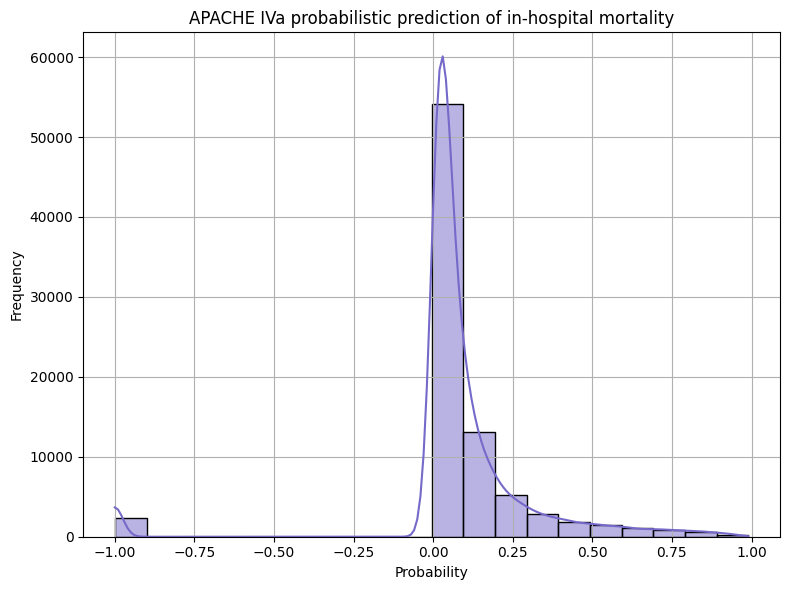

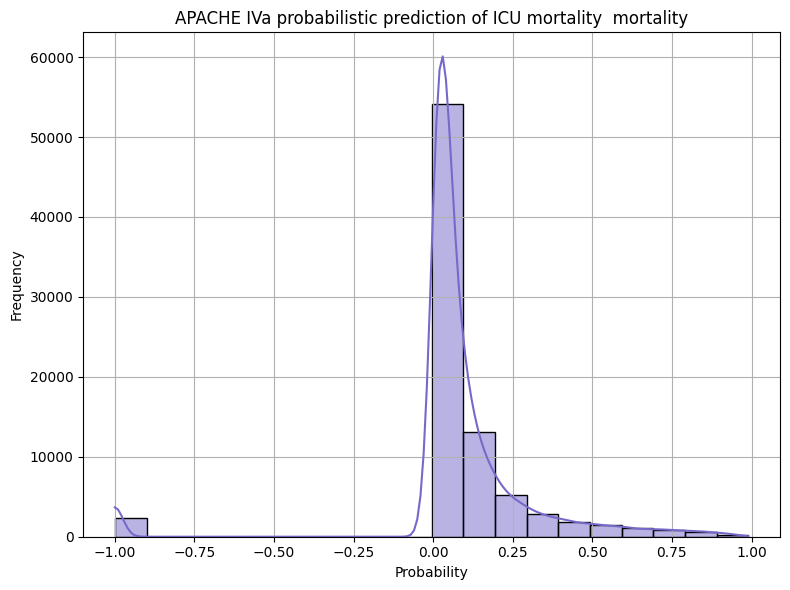

In [ ]:
#Description of APACHE prediction outcomes

#Histogram of the APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
plt.figure(figsize=(8, 6))
sns.histplot(df['apache_4a_hospital_death_prob'], bins=20, kde=True, color='#7569c9')
plt.title('APACHE IVa probabilistic prediction of in-hospital mortality')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

#Histogram of the APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis
plt.figure(figsize=(8, 6))
sns.histplot(df['apache_4a_hospital_death_prob'], bins=20, kde=True, color='#7569c9')
plt.title('APACHE IVa probabilistic prediction of ICU mortality  mortality')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


#I think we have APACHE outliers that we should consider removing


In [ ]:
# Lets look at some strata by comorbidity/condition
print(np.shape(df))
print('There are ' + str(len(df['hospital_id'].unique()))+ ' hospital locations')
print('There are ' + str((df['aids']==1).sum()) + ' patients with aids')
print('There are ' + str((df['cirrhosis']==1).sum()) + ' patients with cirrhosis')
print('There are ' + str((df['diabetes_mellitus']==1).sum()) + ' patients with diabetes mellitus')
print('There are ' + str((df['hepatic_failure']==1).sum()) + ' patients with hepatic failure')
print('There are ' + str((df['immunosuppression']==1).sum()) + ' patients with immunosuppresion')
print('There are ' + str((df['leukemia']==1).sum()) + ' patients with leukemia')
print('There are ' + str((df['lymphoma']==1).sum()) + ' patients with lymphoma')
print('There are ' + str((df['solid_tumor_with_metastasis']==1).sum()) + ' patients with metastasis')

##Dropping Unncessary Features

In [ ]:
# Drop identifiers
df = df.drop(['encounter_id','patient_id','hospital_id'], axis = 1)

# Drop APACHE scores, clinical and systematic variables, and body systems (we want to compare our model to APACHE scoring ability)
df = df.drop(['apache_4a_hospital_death_prob','apache_4a_icu_death_prob','apache_2_diagnosis', 'apache_3j_diagnosis'], axis = 1)
df = df.drop(['apache_3j_bodysystem','apache_2_bodysystem'], axis = 1)
df = df.drop(['albumin_apache','apache_post_operative','arf_apache','bilirubin_apache','bun_apache','creatinine_apache','fio2_apache','gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache','glucose_apache','heart_rate_apache','hematocrit_apache','intubated_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache','resprate_apache','sodium_apache','temp_apache','urineoutput_apache','ventilated_apache','wbc_apache'], axis = 1)

# Drop all blood-gas measurements (we have a lot of vitals and lab stats already)
df = df.drop(['d1_arterial_pco2_max','d1_arterial_pco2_min','d1_arterial_ph_max','d1_arterial_ph_min','d1_arterial_po2_max','d1_arterial_po2_min','d1_pao2fio2ratio_max','d1_pao2fio2ratio_min','h1_arterial_pco2_max','h1_arterial_pco2_min','h1_arterial_ph_max','h1_arterial_ph_min','h1_arterial_po2_max','h1_arterial_po2_min','h1_pao2fio2ratio_max','h1_pao2fio2ratio_min',], axis = 1)

# Drop comorbidities and other conditions (we can stratify or try including later if we want to but for now lets assume these get captured by vitals/lab)
df = df.drop(['aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis'], axis = 1)

print(np.shape(df))
print(df.columns)

##Describing Missing Data

In [ ]:
#Missing data

## Check Missing Values
missing_value_counts = df.isnull().sum()
print(missing_value_counts[missing_value_counts > 0])

labdata = ['d1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min']

#We will use 85% as a threshold for data removal. When a column has more than 85% of data missing it will be dropped.
#Since we have 91713 rows, when a column has 13756 rows or less (77957 or more missing), we will remove that column.

# Filter the missing value counts for only labdata columns
labdata_missing_counts = missing_value_counts[labdata]

# Print the missing value counts for labdata
print(labdata_missing_counts[labdata_missing_counts > 0])

# Calculate the percentage of missing values for each column in labdata
labdata_missing_percent = (labdata_missing_counts / len(df)) * 100

# Sort the percentages in descending order
labdata_missing_percent_sorted = labdata_missing_percent.sort_values(ascending=False)

# Print the sorted missing value percentages for labdata
print("Percentage of Missing Values in Lab Data Columns (from most to least):")
print(labdata_missing_percent_sorted[labdata_missing_percent_sorted > 0])

# Calculate and print the total percentage of missing values across all labdata columns
total_labdata_missing_percent = labdata_missing_counts.sum() / (len(df) * len(labdata)) * 100
print(f"Total percentage of missing values in labdata columns: {total_labdata_missing_percent:.2f}%")

# These columns have missingness split at 53%. There was a distinct break in the data. These are all data taken within the first day.
# We will drop the data above 53% since the split most likely implies some change in severity
# In any case, this data may not be present in many patients (with some unidentified pattern), therefore we will not use it since real data may not contain it either.
low_missingness_labdata = ['d1_hco3_max', 'd1_hco3_min', 'd1_platelets_min', 'd1_platelets_max', 'd1_wbc_min', 'd1_wbc_max', 'd1_calcium_max', 'd1_calcium_min', 'd1_hemaglobin_min', 'd1_hemaglobin_max', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_bun_min','d1_bun_max', 'd1_sodium_max', 'd1_sodium_min', 'd1_creatinine_min', 'd1_creatinine_max', 'd1_potassium_max', 'd1_potassium_min', 'd1_glucose_min', 'd1_glucose_max']
high_missingness_labdata = ['h1_bilirubin_min', 'h1_bilirubin_max', 'h1_lactate_min', 'h1_lactate_max', 'h1_albumin_max', 'h1_albumin_min', 'h1_hco3_min', 'h1_hco3_max', 'h1_wbc_max', 'h1_wbc_min', 'h1_calcium_min', 'h1_calcium_max', 'h1_platelets_min', 'h1_platelets_max', 'h1_bun_max', 'h1_bun_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_hematocrit_min', 'h1_hematocrit_max', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max', 'd1_lactate_min', 'd1_lactate_max', 'h1_inr_max', 'h1_inr_min', 'd1_inr_min', 'd1_inr_max', 'd1_bilirubin_max', 'd1_bilirubin_min', 'h1_glucose_min', 'h1_glucose_max', 'd1_albumin_max', 'd1_albumin_min']

dropcol_85 = (missing_value_counts[missing_value_counts > 77957])
print(dropcol_85)

df = df.drop(high_missingness_labdata + ['h1_albumin_max','h1_albumin_min','h1_bilirubin_max','h1_bilirubin_min','h1_lactate_max','h1_lactate_min'], axis = 1)


##Imputation for Missingness


In [ ]:

#Using MICE for imputation
np.shape(df)
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

print("There are " + str(len(df['ethnicity'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['gender'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['hospital_admit_source'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['icu_admit_source'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['icu_stay_type'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['icu_type'].unique())) + " categories (including NAN)")

#Using  one-hot for all cat columns except hospital admit source which will use label encoding
categorical_columns_hot = categorical_columns.drop(['hospital_admit_source'])

df_enc = df.copy()
for column in categorical_columns_hot:
    encoded = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df_enc = pd.concat([df_enc, encoded], axis=1)
    df_enc.drop(column, axis=1, inplace=True)

# Label Encoding for 'hospital_admit_source'
label_encoder = LabelEncoder()
df_enc['hospital_admit_source'] = label_encoder.fit_transform(df_enc['hospital_admit_source'].astype(str))

# Check the shape of the dataframe after encoding
df_enc.shape

# Initialize the MICE imputer
mice_imputer = IterativeImputer(max_iter=10, random_state=0)

# Apply MICE imputation to the dataset
df_imputed = df_enc.copy()
df_imputed.iloc[:, :] = mice_imputer.fit_transform(df_imputed)

# Checking for missing values after imputation
missing_data_after_imputation = df_imputed.isnull().sum().sum()

missing_data_after_imputation, df_imputed.head()

#plotting histograms post-imputation (see function above)
var_hist = list(df_enc.columns)

# Example of how to use the function
variables_to_check = ['variable1', 'variable2', 'variable3']  # Replace with your actual variable names
plot_histograms(df_enc, df_imputed, var_hist)

# Compute summary statistics before and after imputation
summary_before = df_enc.describe()
summary_after = df_imputed.describe()

summary_diff = summary_after - summary_before
print(summary_diff)

##Checking class balance


In [ ]:
counts = df_imputed['hospital_death'].value_counts()
print('Class Balance')
print(counts)

# Define your color sequence
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in "Class/ASD"',
    color_discrete_sequence=colors  # apply your colors here
)

# Update layout for better appearance
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),  # Adjust top margin to make room for title
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='Class/ASD'
    ),
    title=dict(
        text='Distribution of Classes in "Mortality"',
        x=0.45,  # Centering the title
        xanchor='center',
        y=0.95,  # Adjusting y position to place title above chart
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()


#Neural Networks

In [ ]:
# importing PyTorch library
import torch as t

# importing other necessary libraries
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
import torch as t

# importing PyTorch modules for building neural networks
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout


In [ ]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)


In [ ]:
print(Y_np.shape)
print(X_scaled.shape)

In [ ]:
# Define hyperparameters
number_of_input_features = X_scaled.shape[1]
number_of_hidden_units = 60
epochs = 10
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# K-Fold Cross-Validation setup
k = 5  # Number of folds
kfold = KFold(n_splits=k, shuffle=True)

# Lists to store metrics for each fold
fold_train_losses = []
fold_validation_losses = []

# Lists to store average accuracy across folds for each epoch
avg_train_accuracy_list = [[] for i in range(epochs)]
avg_validation_accuracy_list = [[] for i in range(epochs)]

all_folds_predictions = []
all_folds_actuals = []

for fold, (train_indexes, validation_indexes) in enumerate(kfold.split(X_scaled, Y_np)):
    X_train_fold = X_scaled[train_indexes]
    Y_train_fold = Y_np[train_indexes]
    X_validation_fold = X_scaled[validation_indexes]
    Y_validation_fold = Y_np[validation_indexes]

    # Convert to tensors
    X_train_tensor = t.tensor(X_train_fold).type(t.float32)
    Y_train_tensor = t.tensor(Y_train_fold).type(t.float32)
    X_validation_tensor = t.tensor(X_validation_fold).type(t.float32)
    Y_validation_tensor = t.tensor(Y_validation_fold).type(t.float32)

    # DataLoader for the training data
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define the neural network model with regularization
    model = nn.Sequential(
        nn.Linear(X_train_fold.shape[1], number_of_hidden_units),
        nn.Tanh(),
        nn.Linear(number_of_hidden_units, 1),
        nn.Sigmoid()
    )

    # Define the optimizer
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Define the loss function with Binary Cross-Entropy Loss
    loss_fn = nn.BCELoss()

    # Train the model for this fold
    for epoch in range(epochs):
        if epoch % 5 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.9

        epoch_loss = 0.0
        for batch_idx, (X, Y) in enumerate(train_data_loader):
            # Forward pass: Compute predictions
            probs = model(X)

            # Adding regularization term for all parameters in the model
            l2_term = sum([(w ** 2).sum() for w in model.parameters() if w.requires_grad and w.ndim > 1])

            # New loss is the old loss + regularization term
            loss = loss_fn(probs.view(-1), Y) + landa * l2_term

            # Backward pass: Compute gradient and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Print the average loss for this epoch
        epoch_loss /= len(train_data_loader)
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Average Loss: {epoch_loss:.4f}')


        # Evaluate the model on the train set
        with t.no_grad():
            model.eval()
            train_probs = model(X_train_tensor)
            train_prediction = (train_probs >= 0.5).type(t.LongTensor).view(-1)
            train_accuracy = (train_prediction == Y_train_tensor).type(t.float32).mean().item()
            avg_train_accuracy_list[epoch].append(train_accuracy)

        # Evaluate the model on the validation set
        with t.no_grad():
            validation_probs = model(X_validation_tensor)
            validation_prediction = (validation_probs >= 0.5).type(t.LongTensor).view(-1)
            validation_accuracy = (validation_prediction == Y_validation_tensor).type(t.float32).mean().item()
            avg_validation_accuracy_list[epoch].append(validation_accuracy)

            all_folds_predictions.extend(validation_prediction.numpy())
            all_folds_actuals.extend(Y_validation_tensor.numpy())


# Calculate average accuracy per epoch across all folds
mean_train_accuracy_per_epoch = [np.mean(accuracies) for accuracies in avg_train_accuracy_list]
mean_validation_accuracy_per_epoch = [np.mean(accuracies) for accuracies in avg_validation_accuracy_list]

# Plotting
plt.plot([i for i in range(epochs)], mean_train_accuracy_per_epoch, label="Train")
plt.plot([i for i in range(epochs)], mean_validation_accuracy_per_epoch, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

conf_matrix, class_report, auc, acc = get_scores(all_folds_predictions, all_folds_actuals)
print_scores(conf_matrix, class_report, auc, acc)


